## Librairies

In [1]:
%matplotlib inline

In [2]:
from importlib import reload
from cycler import cycler
from scipy.io  import loadmat
from sklearn   import mixture
from sklearn   import neighbors
from V2XMD     import data_evaluation
from V2XMD     import data_processing
from V2XMD     import data_visualisation
from V2XMD     import plausibility_checks
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import re
import seaborn as sns
import sklearn
import sklearn.metrics
import sys
import time
from V2XMD.models import TrainModel

In [3]:
sns.set_style('dark')

In [4]:
columns_names=[ "type",
                "reception_time",
                "receiver_id",
                "receiver_x_position",
                "receiver_y_position",
                "receiver_z_position",
                "transmission_time" ,
                "transmitter_id",
                "bsm_id",
                "transmitter_x_position",
                "transmitter_y_position",
                "transmitter_z_position",
                "transmitter_x_velocity",
                "transmitter_y_velocity",
                "transmitter_z_velocity",
                "rssi",
                "label"]
dfs=[]

In [5]:
import V2XMD

In [6]:
dfs=[]
for i in [1,2,4,8,16]:
    mat = loadmat('./data/WiSec_DataModifiedVeremi_Dataset-master/attack'+str(i)+'withlabels.mat')['attack'+str(i)+'withlabels']
    df  = pd.DataFrame(mat,columns=columns_names)
    df  = df.assign(dataset=V2XMD.data_visualisation.attack_types[i])
    dfs.append( df)
df = pd.concat(dfs)
df.reset_index(inplace=True,drop=True)
df.dropna(inplace=True)

In [7]:
df.label = df.label.apply(lambda x: V2XMD.data_visualisation.attack_types[x])

In [126]:
df.columns

Index(['type', 'reception_time', 'receiver_id', 'receiver_x_position',
       'receiver_y_position', 'receiver_z_position', 'transmission_time',
       'transmitter_id', 'bsm_id', 'transmitter_x_position',
       'transmitter_y_position', 'transmitter_z_position',
       'transmitter_x_velocity', 'transmitter_y_velocity',
       'transmitter_z_velocity', 'rssi', 'label', 'dataset'],
      dtype='object')

<ipython-input-74-8fc1346602ec>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('label')['receiver_x_position','transmitter_x_position'].apply(lambda x : (plt.figure(),


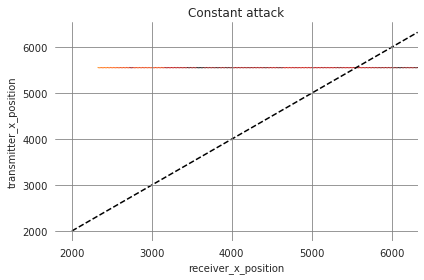

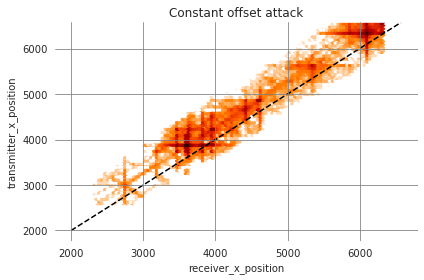

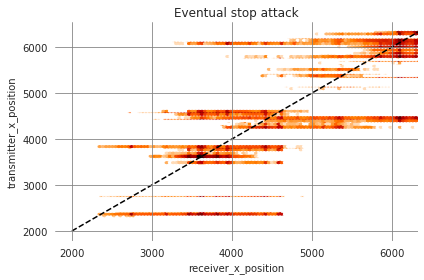

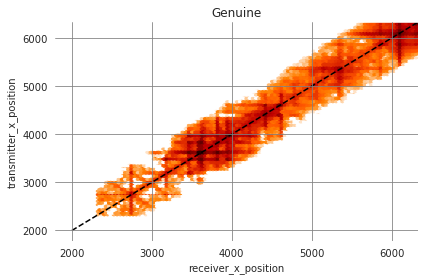

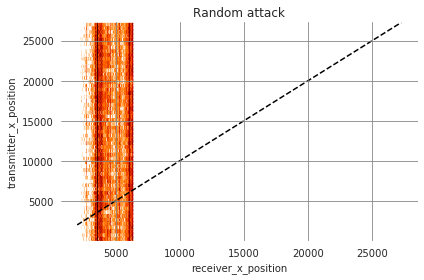

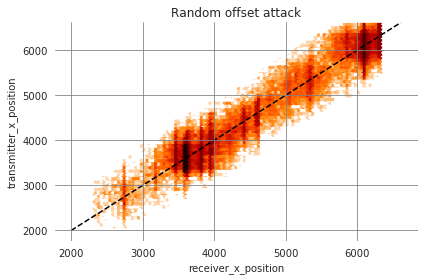

In [74]:
df.groupby('label')['receiver_x_position','transmitter_x_position'].apply(lambda x : (plt.figure(),
                                                                                      plt.hexbin(x['receiver_x_position'],x['transmitter_x_position'],bins='log',cmap="gist_heat_r"),
                                                                                      plt.plot((2000,
                                                                                               max(x['receiver_x_position'].max(),x['transmitter_x_position'].max())),
                                                                                               (2000,
                                                                                               max(x['receiver_x_position'].max(),x['transmitter_x_position'].max())), 
                                                                                               ls="--",c='black'),
                                                                                      plt.title(x.name+' attack'if x.name!='Genuine' else x.name) ,
                                                                                      plt.xlabel('receiver_x_position'),
                                                                                      plt.ylabel('transmitter_x_position'),
                                                                                      plt.gca().set_facecolor((255/255,255/255,255/255)),plt.tight_layout(),
                                                                                      plt.gca().set_axisbelow(False),
                                                                                      plt.grid(True,axis='both', c='grey'),
                                                                                      plt.savefig(x.name+"_density.png",dpi=300))
                                                                         );

In [ ]:
leak_knn_train_results={}
leak_knn_test_results={}
all_train_res=[]
all_test_res=[]
for nb_leaks in np.linspace(10,16301,40).astype(int):
    train_res=[]
    test_res=[]
    for i in range(20):
        leak_nofeature_oneclass_model= TrainModel(df,split='leakage', multi_class=False,features=False,nb_leaks = nb_leaks)
        leak_nofeature_oneclass_model.names=[leak_nofeature_oneclass_model.names[1]]
        leak_nofeature_oneclass_model.classifiers=[leak_nofeature_oneclass_model.classifiers[1]]
        leak_nofeature_oneclass_model.train()
        train_res.append(leak_nofeature_oneclass_model.train_results['Decision Tree']['f1-score'].loc['Random offset'].values[0])
        test_res.append(leak_nofeature_oneclass_model.test_results['Decision Tree']['f1-score'].loc['Random offset'].values[0])
    all_train_res.append(train_res)
    all_test_res.append(test_res)

    leak_knn_train_results[nb_leaks]=np.mean(train_res)
    leak_knn_test_results[nb_leaks]=np.mean(test_res)
    print(leak_knn_train_results[nb_leaks],leak_knn_test_results[nb_leaks])

leakable train messages : 79640
leakable validaion messages : 16301


In [127]:
res = pd.concat((pd.Series(leak_knn_train_results),pd.Series(leak_knn_test_results)),axis=1,keys=['Validation','test'])

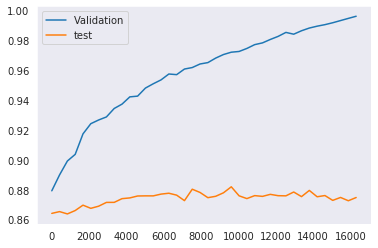

In [128]:
res.plot()


In [129]:
full_res=pd.concat([
    pd.DataFrame(
        data =all_train_res,
        index =np.linspace(10,16301,40).astype(int)*2
    ).stack().reset_index().set_axis(['leaky messages','tries','f1-score'],axis=1).assign(subset='Validation')
    ,
    pd.DataFrame(
        data = all_test_res,
        index =np.linspace(10,16301,40).astype(int)*2
    ).stack().reset_index().set_axis(['leaky messages','tries','f1-score'],axis=1).assign(subset='test')
    ]
    )

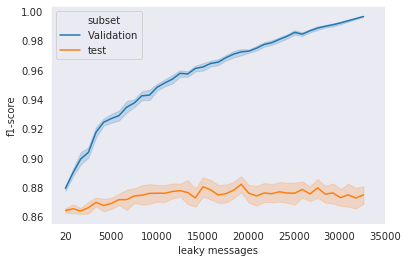

In [134]:
sns.lineplot(data=full_res, x="leaky messages", y="f1-score",hue='subset')
plt.xticks([20,5000,10000,15000,20000,25000,30000,35000])
plt.savefig("evolution_leakage.png",dpi=300)